In [ ]:
%%time 
%reload_ext autoreload
%autoreload 2
from utils.tranformer import *
from utils.helpers import *
from utils.imports import *

# instantiate model
model = DecoderTransformer(vocab_size)
model = nn.DataParallel(model)
model = model.to(device) # move model parameters to gpu if available

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
val_data, val_urls = load_val_data(num_pages=10)
train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add=10e5, printer=True)


CUDA_VISIBLE_DEVICES = 1
device: cuda
num_params: 10M
n_layer: 6
d_model: 384
n_head:  6
d_head:  64
learning_rate:  0.0003

crawl_wiki_data: add=1.00M characters... 

In [ ]:
%%time
step = 0

# Create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # usually 3e-4 for bigger networks.

list_epochs, list_losses, list_epochs_eval, list_losses_eval = [0], [], [0], [] 

xb, yb, pivot = get_batch(train_data, batch_size, pivot=0)

logits, loss = model(xb, yb)
if device.startswith('cuda') and torch.cuda.device_count() > 1:
    loss = np.mean(loss.tolist())
list_losses.append(loss.tolist())
losses = estimate_loss(model, train_data, val_data, 0, time.time())

list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])

print(f'logits.shape (block_size * batch_size) = {logits.shape}')
print(f'loss: {loss:.3f}')
generate_text(model, step);


In [ ]:
# train loop
start = time.time()

while step < max_iters:
    step += 1
    epoch = step * batch_size * block_size  # epoch is num of tokens ingested.
    sample_no = step * batch_size 

    # sample a batch of data
    xb, yb, pivot = get_batch(train_data, batch_size, pivot)

    while len(xb) < batch_size:
        repo_xb, repo_yb, pivot = xb, yb, 0
        train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add, printer=False)
        xb, yb, pivot = get_batch(train_data, batch_size-len(xb), pivot)
        xb = torch.cat((repo_xb, xb))
        yb = torch.cat((repo_yb, yb))

    # evaluate the loss
    logits, loss = model(xb, yb)
    if device.startswith('cuda') and torch.cuda.device_count() > 1:
        loss = loss.mean()
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # get the gradients
    optimizer.step() # update parameters using the gradients

    list_losses.append(loss.item())
    list_epochs.append(sample_no)

    # evaluate at fixed intervals
    if sample_no % eval_interval == 0 or step == max_iters:
        losses = estimate_loss(model, train_data, val_data, step, start)
        list_epochs_eval.append(sample_no)
        list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])
        plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval, step)
        generate_text(model, step, start)

    if step % 10 == 0: 
        print(f'step:{step:3d}  {print_runtime(start, False)}')


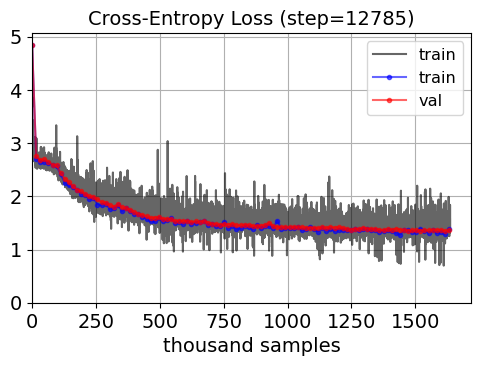

step:12785   (...Runtime: 718 min 24 sec)


In [7]:
plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval, step)
print(f'step:{step:3d}  {print_runtime(start, False)}')
generate_text(model, step, start)


In [10]:
generate_text(model, step, start)


  ===>  Text Generation: A Was after his most approach, Authorities and HBN.
Full that was locked as Spanish Nations.
Fuel return Third Short won minimum, Bostol's writer, was assigned only 103 in Washington, New York (Nationalist').[189]
While it carried (The Scatlerdt)[edit]
Full team: Champions Fuel earnered a writer occurred to date to its language: The Champions Fuels from Hazard showyl Lord title in The Hazard of All


# todo 
- check if `batch_size` designates number of batches per each GPU or the total batches of 8 GPUs.
- ~`get_batches` should get partial batches if it runs out of sentences~
- `get_batches` should process one wiki page at a time. 
- Use `tiktoken` tokenizer


# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's anodes in a graph looking at each other and aggregating informtaion with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

## 2. Experiments
---

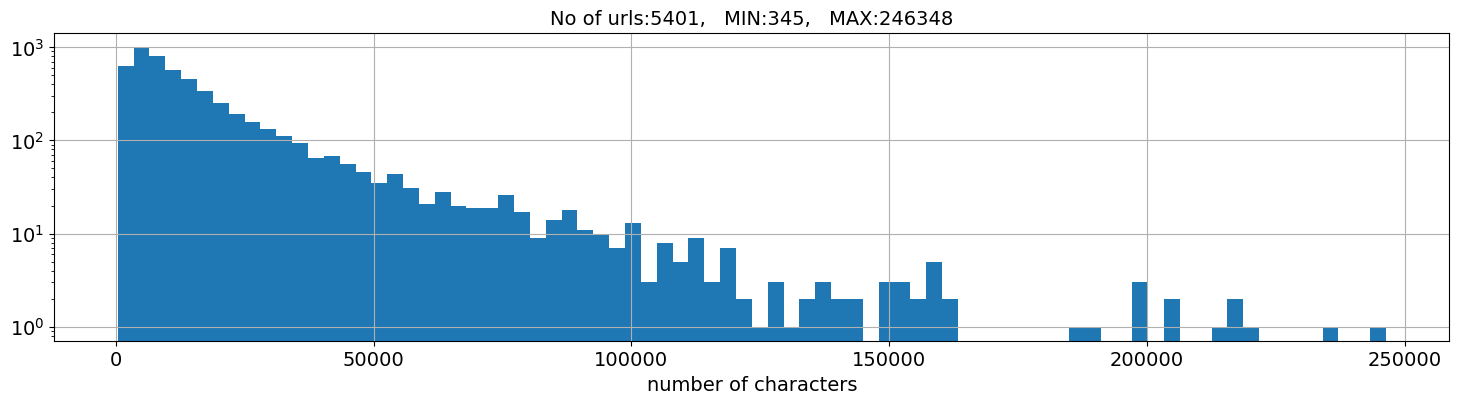

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


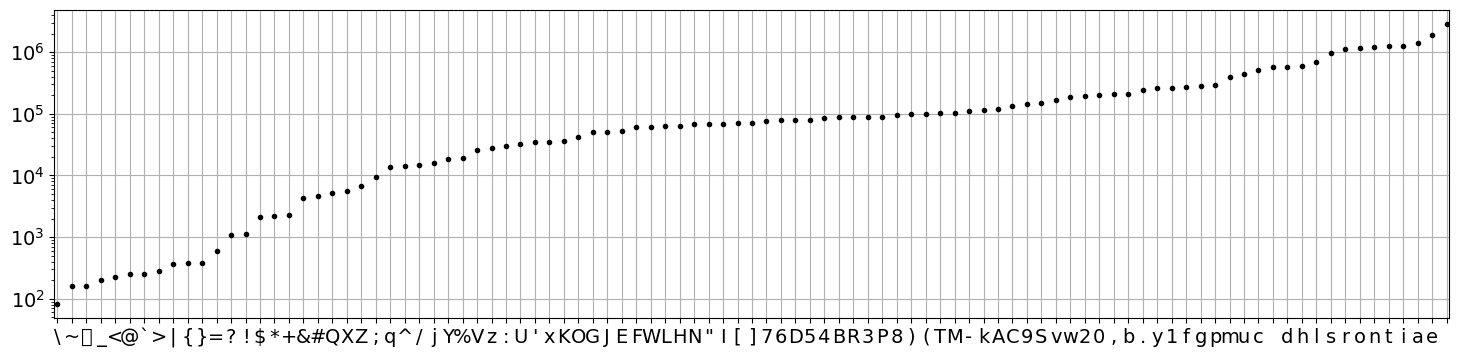

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)